# CRN/FBA composite with Vivarium

## Overview
This notebook combines a chemical reaction network model with a flux balance analysis model, and a physics enging

In [1]:
#@title install vivarium libraries

#Uncomment in Colab Below

"""
%%capture
!pip install git+https://github.com/vivarium-collective/vivarium-notebooks
!pip install vivarium-core==0.1.5
!pip install vivarium-cobra==0.0.6
!pip install vivarium-pymunk==0.0.2
!pip install vivarium-bioscrape
"""

'\n%%capture\n!pip install git+https://github.com/vivarium-collective/vivarium-notebooks\n!pip install vivarium-core==0.1.5\n!pip install vivarium-cobra==0.0.6\n!pip install vivarium-pymunk==0.0.2\n!pip install vivarium-bioscrape\n'

In [2]:
#@title imports
import numpy as np
import pylab as plt

from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, get_iAF1260b_config, print_growth)
from vivarium_bioscrape.processes.bioscrape import (
    Bioscrape
)

# process/composition interface
from vivarium.core.process import (
    Process, Deriver, Composite,
)

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    FACTORY_KEY,
)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# vivarium plotting functions
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

In [3]:
config =get_iAF1260b_config()
print(config)

{'model_path': '/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/vivarium_cobra/bigg_models/iAF1260b.json'}


# Flux Balance Analysis with COBRA

 * This process is a wrapper for the popular FBA solver [COBRA](https://cobrapy.readthedocs.io/en/latest/).
 * Metabolism is initialized with a [BiGG metabolic model](http://bigg.ucsd.edu) called *iAF1260b*, which has 2382 reactions, 1261 genes, and 166 metabolites.

In [4]:
# plotting function for metabolism output
def plot_metabolism(data, ncol=2):
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})
    
    # initialize subplots
    n_rows = 2
    n_cols = 2
    fig = plt.figure(figsize=(n_cols * 7, n_rows * 3))
    grid = plt.GridSpec(n_rows, n_cols)
    
    time_vec = data['time']
    
    # mass
    ax = fig.add_subplot(grid[0, 0])  
    ax.plot(time_vec, data['global'][('mass', 'femtogram')], label = 'mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
#     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # external
    ax = fig.add_subplot(grid[0, 1])  
    for mol_id, series in data['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # internal
    ax = fig.add_subplot(grid[1, 1])  
    for mol_id, series in data['internal_counts'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')
    fig.tight_layout()
    plt.rcParams.update({'font.size': original_fontsize})

In [22]:
from vivarium_cobra.composites.cobra_composite import CobraComposite

# get the configuration for the iAF1260b BiGG model
cobra_config = get_iAF1260b_config()
cobra_config.update({
    'time_step': 10
})
config = {
    'cobra': cobra_config
}   

# load it into DynamicFBA
metabolism = CobraComposite(config)

# get the model's initial state
initial_state = metabolism.initial_state({}) 

# run simulation
sim_settings = {
    'initial_state': initial_state,
    'total_time': 2500}
cobra_timeseries = simulate_compartment_in_experiment(metabolism, sim_settings)


Experiment ID: f59303f4-5b63-11eb-8b2b-acde48001122
Created: 01/20/2021 at 13:10:44
Completed in 31.75 seconds


volume growth: 1.9537412863469115
mass growth: 1.9537412863469115


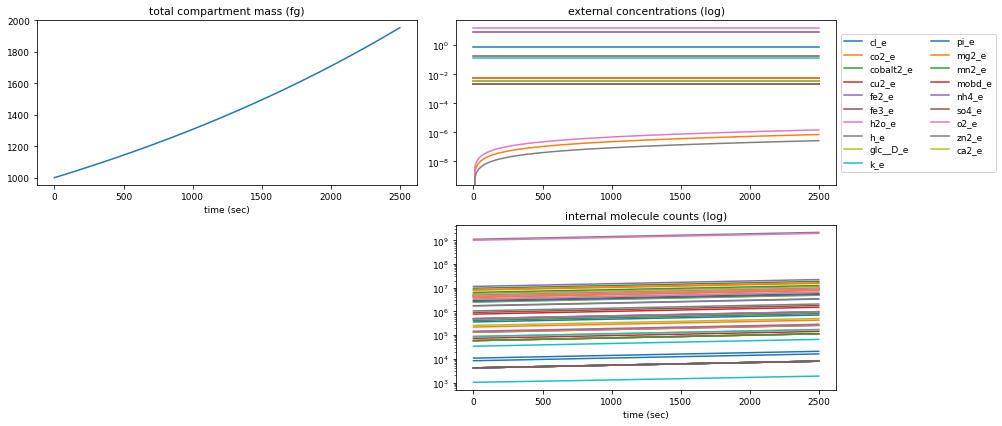

In [9]:
print_growth(cobra_timeseries['global'])
plot_metabolism(cobra_timeseries)

# Chemical Reaction Network with SBML 

In [10]:
time_step = 1
total_time = 2500

# initialize Bioscrape process
bioscrape_config = {
    'sbml_file': 'LacOperon_simple.xml',
    'time_step': time_step}
bioscrape_process = Bioscrape(bioscrape_config)

# initial state
initial_state = bioscrape_process.initial_state()

# run simulation
settings = {
    'total_time': total_time,
    'initial_state': initial_state,
    'display_info': False,
    'progress_bar': False}
bioscrape_timeseries = simulate_process_in_experiment(bioscrape_process, settings)

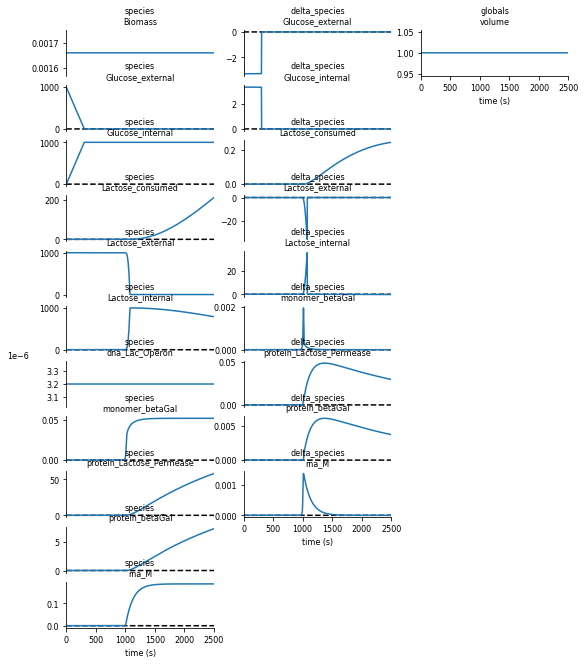

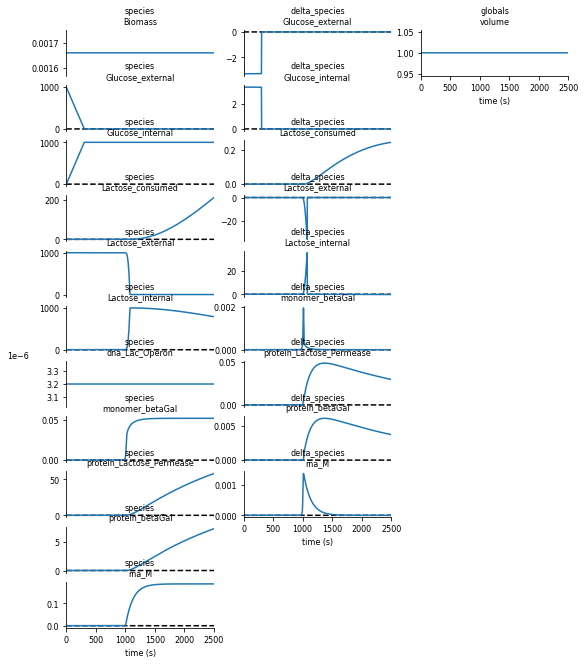

In [11]:
plot_simulation_output(bioscrape_timeseries)

# Multibody physics with pymunk

In [12]:
from vivarium_pymunk.processes.multibody_physics import Multibody

# TODO -- minimal Growth/Division example here

# CRN/FBA Composite

This also includes FluxDeriver and imported division processes

In [13]:
# This works for deterministic/smooth dynamics, stochastic requires something else.
# calculate weighted average back in time? 
# use delta since this was last used. get average delta based on COBRA's last update, use COBRA's timestep?

class FluxDeriver(Deriver):
    defaults = {
        'time_step': 1,
        'flux_keys': []
    }

    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'deltas': {
                flux_key: {'_default': 0.0}
                for flux_key in self.parameters['flux_keys']
            },
            'fluxes': {
                flux_key: {'_default': 0.0}
                for flux_key in self.parameters['flux_keys']
            }
        }


    def next_update(self, timestep, states):
        deltas = states['deltas']
        update = {
            'fluxes': {
                reaction_id: delta / self.parameters['time_step']
                for reaction_id, delta in deltas.items()}}
        return update
    

In [18]:
from vivarium.processes.tree_mass import TreeMass
from vivarium_cobra.processes.volume import Volume


class BioscrapeCobra(Composite):
    # bioscrape's ('species', 'Biomass') needs to be updated to a 'set' updater rather than 'accumulate'
    # units for Biomass is in mmol/L of a species with mw of 1 fg/L
    # import of Glucose is also in terms of 'Biomass' species
    # stochastically, it is in counts. Volume
    # everything is being degraded by dilution -- to turn it off,

    # set cobra constrained reactions
    cobra_config = get_iAF1260b_config()
    cobra_config.update({
        'time_step': 1  # TODO -- relax this later, once flux deriver is configured
    })

    defaults = {
        'bioscrape': {
            'sbml_file': 'LacOperon_simple_no_dilution.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
        },
        'cobra': cobra_config,
        'flux_deriver': {
            'flux_keys': [
                'Lactose_consumed',
                'Glucose_internal']
        },
    }

    def generate_processes(self, config):

        bioscrape_process = Bioscrape(config['bioscrape'])

        cobra_process = DynamicFBA(config['cobra'])

        flux_deriver = FluxDeriver(config['flux_deriver'])

        return {
            'bioscrape': bioscrape_process,
            'cobra': cobra_process,
            'mass_deriver': TreeMass(),
            'volume_deriver': Volume(),
            'flux_deriver': flux_deriver,
        }

    def generate_topology(self, config):
        globals_path = ('globals',)
        # TODO -- get names mapped to fluxes
        # TODO -- 'Lactose_internal', 'Lactose_external' need to get wired to ('external',),
        # TODO -- logic for counts/concentrations if stochastic/deterministic based on bioscrape's 'stochastic'

        stochastic = config['bioscrape']['stochastic']

        return {
            'bioscrape': {
                'species': ('species',),  # TODO connect 'Biomass' variable to ('globals', 'biomass')
                'delta_species': ('delta_species',),
                'rates': ('rates',),
                'globals': globals_path,
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': ('external',),
                'exchanges': ('exchanges',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': globals_path,  #
            },
            'flux_deriver': {
                'deltas': ('delta_species',),  # TODO connect to 'Lactose_consumed', 'Glucose_internal'
                'fluxes': ('flux_bounds',),  # needs to convert to 'EX_lac__D_e', 'EX_glc__D_e'
            },
            'mass_deriver': {
                'global': globals_path,
            },
            'volume_deriver': {
                'global': globals_path,
            },
        }
        

In [19]:
config = {}
composite = BioscrapeCobra(config)

initial_state = composite.initial_state()
settings = {
    'initial_state': initial_state,
    'total_time': 100,
}
bioscrape_cobra_output = simulate_compartment_in_experiment(composite, settings)



Experiment ID: aac08ea0-5b63-11eb-8b2b-acde48001122
Created: 01/20/2021 at 13:08:38
Completed in 6.39 seconds


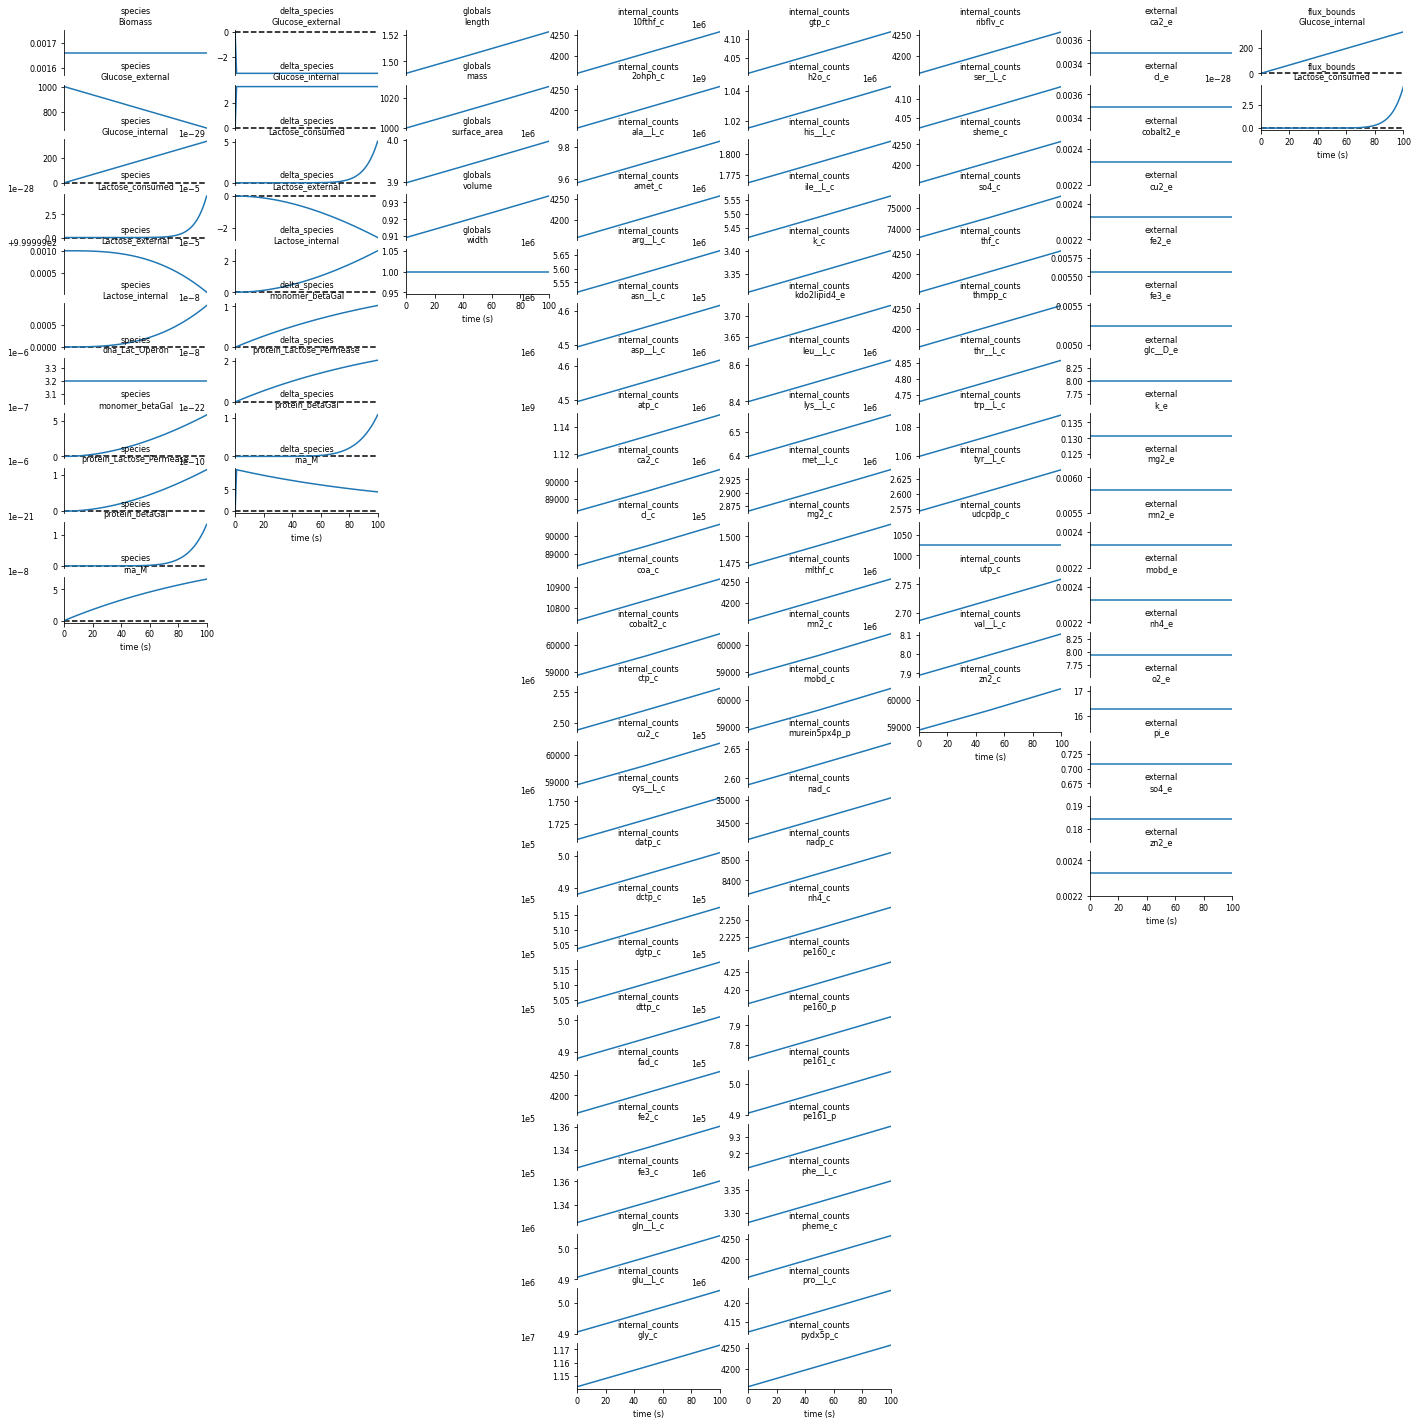

In [20]:
fig = plot_simulation_output(
        bioscrape_cobra_output)

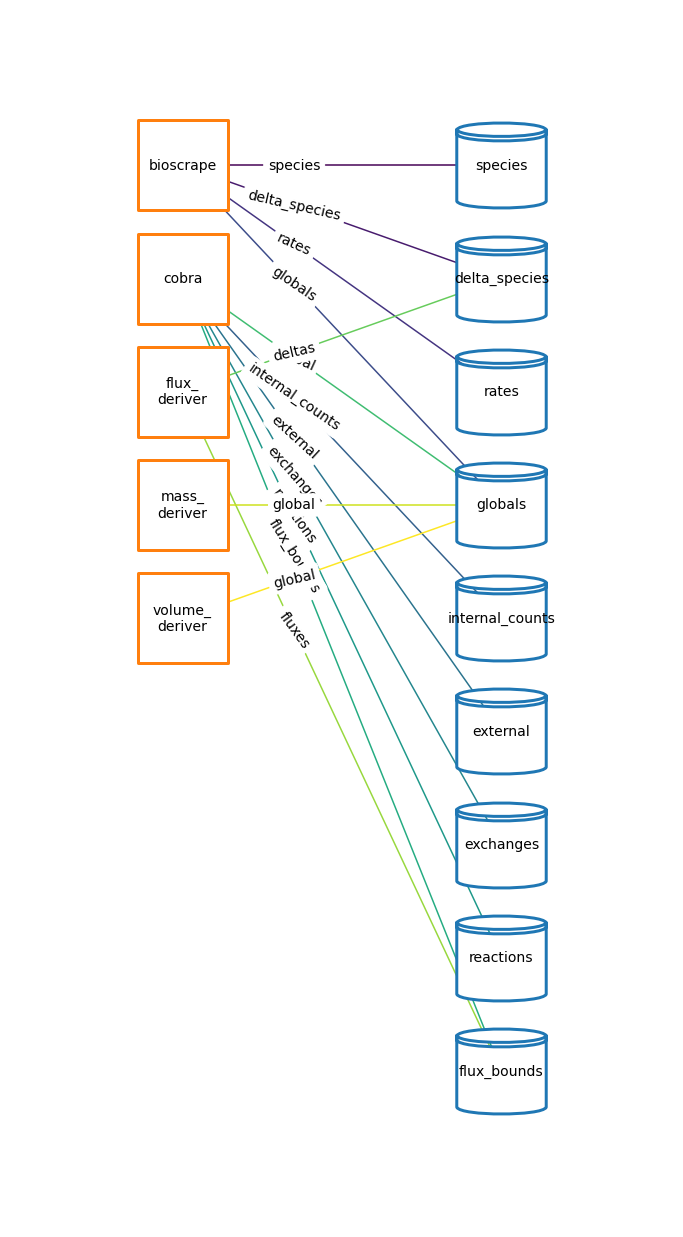

In [21]:
fig = plot_topology(composite)

In [ ]:
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision
    
class CRN_COBRA_division(Composite):
    name = 'crn_cobra'
    defaults = {
        'agent_id': np.random.randint(0, 100),
        'crn': {
            'sbml_file': 'LacOperon_simple.xml',
        },
        'cobra': get_metabolism_config(),
        'divide_condition': {
            'threshold': 2000 * units.fg
        },
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple(),
        '_schema': {
            'cobra': {
                'flux_bounds': {
                    '*': {
                        '_emit': True
                    }
                }
            }
        }
    }

    def generate_processes(self, config):
        # TODO -- reaction names from CRN needs to be matched with COBRA

        processes = {
            'crn': Bioscrape(config['crn']),
            'cobra': DynamicFBA(config['cobra'])}

        # configure derivers
        flux_config = {
            'time_step': processes['crn'].local_timestep()}
        division_config = dict(
            daughter_path=config['daughter_path'],
            agent_id=config['agent_id'],
            compartment=self)

        derivers = {
            'flux_deriver': FluxDeriver(flux_config),
            #             'divide_condition': DivideCondition(config['divide_condition']),
            #             'globals_deriver': DeriveGlobals({}),
            #             'division': MetaDivision(division_config),
        }

        return {**processes, **derivers}

    def generate_topology(self, config):
        return {
            'crn': {
                'species': ('species',),
                'delta_species': ('delta_species',),
                'rates': ('rates',),
                'globals': ('globals',),
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': ('external',),
                'exchanges': ('exchanges',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': ('global',),
            },
            'flux_deriver': {
                'deltas': ('delta_species',),  # TODO -- need to add units!
                'fluxes': ('flux_bounds_2',),
            },
            #             'globals_deriver': {
            #                 'global': ('boundary',)
            #             },
            #             'divide_condition': {
            #                 'variable': ('boundary', 'mass',),
            #                 'divide': ('boundary', 'divide',)
            #             },
            #             'division': {
            #                 'global': ('boundary',),
            #                 'agents': config['agents_path']
            #             }
        }

In [ ]:
composite = CRN_COBRA({})
fig = plot_compartment_topology(composite)

In [ ]:
# plotting function for metabolism output
def plot_composite(data, ncol=2):
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})
    
    # initialize subplots
    n_rows = 2
    n_cols = 2
    fig = plt.figure(figsize=(n_cols * 7, n_rows * 3))
    grid = plt.GridSpec(n_rows, n_cols)
    
    time_vec = data['time']
    
    # mass
    ax = fig.add_subplot(grid[0, 0])  
    ax.plot(time_vec, data['agents']['1']['global'][('mass', 'femtogram')], label = 'mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # external
    ax = fig.add_subplot(grid[0, 1])  
    for mol_id, series in data['agents']['1']['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # internal
    ax = fig.add_subplot(grid[1, 1])  
    for mol_id, series in data['agents']['1']['internal_counts'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')
    
    # layout
    fig.tight_layout()
    plt.rcParams.update({'font.size': original_fontsize})

## simulate CRN/FBA composite

In [ ]:
agent_id = '1'
time_step = 10
total_time = 2000
volume=1e-5 * units.L

# initialize composite
cobra_config = get_iAF1260b_config()
cobra_config.update({
    'time_step': time_step,
    'bin_volume': volume})
crn_config = {'time_step': time_step}

composite_config = {
    'agent_id': agent_id,
    'crn': crn_config,
    'cobra': cobra_config}

composite = CRN_COBRA(composite_config)

# get initial state
initial_state = {
    'agents': {
        '1': composite.initial_state()}}

# make the experiment
sim_settings = {
    'initial_state': initial_state,
    'outer_path': ('agents', agent_id,)}
composite_experiment = compartment_in_experiment(composite, sim_settings)

# run simulation
composite_experiment.update(total_time)

In [ ]:
# retrieve data and plot
composite_timeseries = composite_experiment.emitter.get_timeseries()
print_growth(composite_timeseries['agents']['1']['global'])
plot_composite(composite_timeseries)

In [ ]:
# plot output
plot_settings = {
    'remove_flat': True}
fig = plot_simulation_output(composite_timeseries, plot_settings)

# Simulate CRN/FBA in a Spatial Environment with pymunk
 * We here plug GrowDivide into a composite called Lattice, which has a multi-body physics process (MBP) and a spatial diffusion process (DFF).

In [ ]:
# Environment model with multi-body physics engine and discrete concentration diffusion
from vivarium_cell.composites.lattice import (
    Lattice,
    make_lattice_config)

# configure the lattice environment
lattice_bounds = [15, 15]
lattice_config = make_lattice_config(
    jitter_force=1e-5,
    bounds=lattice_bounds,
    n_bins=[10, 10],
    time_step=30)

# experiment settings to hide info from being plotted
experiment_settings = {'progress_bar': False, 'display_info': False}

In [ ]:
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision
from vivarium_cell.processes.derive_globals import DeriveGlobals

class ExponentialGrowth(Process):

    name = 'exponential_growth'
    defaults = {
        'growth_rate': 0.0005,
        'growth_noise': 1e-4}
    
    def __init__(self, parameters=None):
        super(ExponentialGrowth, self).__init__(parameters)
    
    def ports_schema(self):
        return {
            'port1': {
                'mass': {
                    '_default': 1000.0 * units.fg,
                    '_updater': 'set',
                    '_divider': 'split',
                    '_emit': True}}}
    

    def next_update(self, timestep, states):
        mass = states['port1']['mass']
        new_mass = mass * (
            np.exp(self.parameters['growth_rate'] +
                   np.random.normal(0,self.parameters['growth_noise'])
                  ) * timestep)
        return {
            'port1': {
                'mass': new_mass}}

class GrowDivide(Generator):
    name = 'grow_divide'
    defaults = {
        'agent_id': np.random.randint(0,100),
        'exponential_growth': {'growth_noise': 1e-3},
        'divide_condition': {'threshold': 2000 * units.fg},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple()}

    def __init__(self, config):
        super(GrowDivide, self).__init__(config)
    
    def generate_processes(self, config):
        division_config = dict(
            daughter_path=config['daughter_path'], 
            agent_id=config['agent_id'], 
            compartment=self)
        return {
            'exponential_growth': ExponentialGrowth(config['exponential_growth']),
            'divide_condition': DivideCondition(config['divide_condition']),
            'globals_deriver': DeriveGlobals({}),
            'division': MetaDivision(division_config)}

    def generate_topology(self, config):
        return {
            'exponential_growth': {
                'port1': ('boundary',)},
            'globals_deriver': {
                'global': ('boundary',)},
            'divide_condition': {
                'variable': ('boundary', 'mass',),
                'divide': ('boundary', 'divide',)},
            'division': {
                'global': ('boundary',),
                'agents': config['agents_path']}}

In [ ]:
# GrowDivide requires an 'agent_id' for the division process to track agents
agent_id = '0'
gd_params = {
    'agent_id': agent_id,
    'growth_rate': {
        'growth_rate': 0.001}}

initial_state = {
    'agents': {
        agent_id: {
            'mass': 1000 * units.fg}}}

gd_sim_settings = {
    'initial_state': initial_state,
    'outer_path': ('agents', agent_id),
    'display_info': False,
    'progress_bar': False}

gd_plot_settings = {
    'column_width': 12,
    'include_paths': [
        ('boundary', 'mass')]}

In [ ]:
# declare the hierarchy, with a GrowDivide agent within an 'agents' store
hierarchy = {
    GENERATORS_KEY: {
        'type': Lattice,
        'config': lattice_config},
    'agents': {
        agent_id: {
            GENERATORS_KEY: {
                'type': GrowDivide,
                'config': gd_params}}}}

# configure experiment with helper function compose_experiment
experiment = compose_experiment(
    hierarchy=hierarchy, 
    settings=experiment_settings)

# run the experiment
experiment.update(800)
lattice_output = experiment.emitter.get_data()

In [ ]:
from vivarium_cell.plots.multibody_physics import plot_tags, plot_snapshots

# extract data
agents = {time: time_data['agents'] for time, time_data in lattice_output.items()}
fields = {time: time_data['fields'] for time, time_data in lattice_output.items()}
plot_data = {
    'agents': agents,
    'fields': fields,
    'config': {'bounds': lattice_bounds},
}
plot_config = {
    'include_fields': [],
    'n_snapshots': 5,
    'default_font_size': 36
}

plot_snapshots(plot_data, plot_config)